In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf

from torch.autograd import Variable
from torchvision.models import resnet18

from tensorflow import keras
from keras.preprocessing import image

import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

torch.manual_seed(777)

In [ ]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
tb = TensorBoardColab()

In [10]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=6, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [11]:
class EmbedNet(nn.Module):
    def __init__(self, base_model, net_vlad):
        super(EmbedNet, self).__init__()
        self.base_model = base_model
        self.net_vlad = net_vlad

    def forward(self, x):
        x = self.base_model(x)
        embedded_x = self.net_vlad(x)
        return embedded_x
      
class TripletNet(nn.Module):
    def __init__(self, embed_net):
        super(TripletNet, self).__init__()
        self.embed_net = embed_net

    def forward(self, a, p, n):
        embedded_a = self.embed_net(a)
        embedded_p = self.embed_net(p)
        embedded_n = self.embed_net(n)
        return embedded_a, embedded_p, embedded_n

    def feature_extract(self, x):
        return self.embed_net(x)

In [12]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.1)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (~i_equal_k)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

In [13]:
# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4,
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=6, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad).cuda()

In [14]:
# Define loss
criterion = HardTripletLoss(margin=0.1).cuda()
epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [15]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),               
    torchvision.transforms.ToTensor()
    
])

bef_train_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/F4-E5/train', transform=transforms)
bef_train_data_loader = torch.utils.data.DataLoader(bef_train_imagenet_data,
                                          batch_size=776,
                                          shuffle=False,
                                          num_workers=0)

In [17]:
for bef_train_image,bef_train_label in bef_train_data_loader :
#     print(bef_train_image)
#     print(bef_train_lable)
    bef_train_image = bef_train_image
    bef_train_label = bef_train_label

In [18]:
train_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/F4-E5/train', transform=transforms)
train_data_loader = torch.utils.data.DataLoader(train_imagenet_data,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=0)
test_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/F4-E5/test', transform=transforms)
test_data_loader = torch.utils.data.DataLoader(test_imagenet_data,
                                          shuffle=False,
                                          batch_size=100,
                                          num_workers=0)

In [19]:
globaliter = 0

for epoch in range(epochs):
  for batch_idx, (train_image,train_label) in enumerate(train_data_loader) :
    output_train = model(train_image.cuda())
    triplet_loss = criterion(output_train, train_label.cuda())
    optimizer.zero_grad()
    triplet_loss.backward(retain_graph=True)
    optimizer.step()
    # This is where I'm recording to Tensorboard
    # tb.save_value('Train Loss', 'train_loss', globaliter, triplet_loss.item())
    print('epoch : {}, globaliter : {}, batch_idx  : {}, triplet_loss : {}'.format(epoch,globaliter,batch_idx,triplet_loss.item()))
    globaliter += 1
  model_save_name = 'model_{:02d}.pt'.format(epoch)
  path = F"./{model_save_name}" 
  torch.save(model.state_dict(), path)

epoch : 0, globaliter : 0, batch_idx  : 0, triplet_loss : 0.0996098741889
epoch : 0, globaliter : 1, batch_idx  : 1, triplet_loss : 0.09398002177476883
epoch : 0, globaliter : 2, batch_idx  : 2, triplet_loss : 0.09694953262805939
epoch : 0, globaliter : 3, batch_idx  : 3, triplet_loss : 0.09913714975118637
epoch : 0, globaliter : 4, batch_idx  : 4, triplet_loss : 0.0979781374335289
epoch : 0, globaliter : 5, batch_idx  : 5, triplet_loss : 0.09499441087245941
epoch : 0, globaliter : 6, batch_idx  : 6, triplet_loss : 0.09755291044712067
epoch : 0, globaliter : 7, batch_idx  : 7, triplet_loss : 0.09999975562095642
epoch : 0, globaliter : 8, batch_idx  : 8, triplet_loss : 0.097816102206707
epoch : 0, globaliter : 9, batch_idx  : 9, triplet_loss : 0.09626775979995728
epoch : 0, globaliter : 10, batch_idx  : 10, triplet_loss : 0.09813741594552994
epoch : 0, globaliter : 11, batch_idx  : 11, triplet_loss : 0.09918225556612015
epoch : 0, globaliter : 12, batch_idx  : 12, triplet_loss : 0.09829

epoch : 2, globaliter : 104, batch_idx  : 16, triplet_loss : 0.09808814525604248
epoch : 2, globaliter : 105, batch_idx  : 17, triplet_loss : 0.09499992430210114
epoch : 2, globaliter : 106, batch_idx  : 18, triplet_loss : 0.09564033895730972
epoch : 2, globaliter : 107, batch_idx  : 19, triplet_loss : 0.0967225581407547
epoch : 2, globaliter : 108, batch_idx  : 20, triplet_loss : 0.09902751445770264
epoch : 2, globaliter : 109, batch_idx  : 21, triplet_loss : 0.09294738620519638
epoch : 2, globaliter : 110, batch_idx  : 22, triplet_loss : 0.09717116504907608
epoch : 2, globaliter : 111, batch_idx  : 23, triplet_loss : 0.09516163170337677
epoch : 2, globaliter : 112, batch_idx  : 24, triplet_loss : 0.09411732852458954
epoch : 2, globaliter : 113, batch_idx  : 25, triplet_loss : 0.09528125077486038
epoch : 2, globaliter : 114, batch_idx  : 26, triplet_loss : 0.09801419079303741
epoch : 2, globaliter : 115, batch_idx  : 27, triplet_loss : 0.09266623854637146
epoch : 2, globaliter : 116, 

epoch : 4, globaliter : 206, batch_idx  : 30, triplet_loss : 0.09698019176721573
epoch : 4, globaliter : 207, batch_idx  : 31, triplet_loss : 0.08675502240657806
epoch : 4, globaliter : 208, batch_idx  : 32, triplet_loss : 0.09807343035936356
epoch : 4, globaliter : 209, batch_idx  : 33, triplet_loss : 0.08533375710248947
epoch : 4, globaliter : 210, batch_idx  : 34, triplet_loss : 0.0898343026638031
epoch : 4, globaliter : 211, batch_idx  : 35, triplet_loss : 0.0954209640622139
epoch : 4, globaliter : 212, batch_idx  : 36, triplet_loss : 0.08552033454179764
epoch : 4, globaliter : 213, batch_idx  : 37, triplet_loss : 0.09106827527284622
epoch : 4, globaliter : 214, batch_idx  : 38, triplet_loss : 0.09563059359788895
epoch : 4, globaliter : 215, batch_idx  : 39, triplet_loss : 0.0960155799984932
epoch : 4, globaliter : 216, batch_idx  : 40, triplet_loss : 0.08823841065168381
epoch : 4, globaliter : 217, batch_idx  : 41, triplet_loss : 0.09121938049793243
epoch : 4, globaliter : 218, ba

epoch : 7, globaliter : 309, batch_idx  : 1, triplet_loss : 0.06533632427453995
epoch : 7, globaliter : 310, batch_idx  : 2, triplet_loss : 0.08628872036933899
epoch : 7, globaliter : 311, batch_idx  : 3, triplet_loss : 0.08120335638523102
epoch : 7, globaliter : 312, batch_idx  : 4, triplet_loss : 0.08981965482234955
epoch : 7, globaliter : 313, batch_idx  : 5, triplet_loss : 0.09152892231941223
epoch : 7, globaliter : 314, batch_idx  : 6, triplet_loss : 0.06656532734632492
epoch : 7, globaliter : 315, batch_idx  : 7, triplet_loss : 0.08212585002183914
epoch : 7, globaliter : 316, batch_idx  : 8, triplet_loss : 0.06808029115200043
epoch : 7, globaliter : 317, batch_idx  : 9, triplet_loss : 0.07846754044294357
epoch : 7, globaliter : 318, batch_idx  : 10, triplet_loss : 0.07396190613508224
epoch : 7, globaliter : 319, batch_idx  : 11, triplet_loss : 0.07310537993907928
epoch : 7, globaliter : 320, batch_idx  : 12, triplet_loss : 0.07006142288446426
epoch : 7, globaliter : 321, batch_id

epoch : 9, globaliter : 412, batch_idx  : 16, triplet_loss : 0.0790625587105751
epoch : 9, globaliter : 413, batch_idx  : 17, triplet_loss : 0.06274159997701645
epoch : 9, globaliter : 414, batch_idx  : 18, triplet_loss : 0.03838770091533661
epoch : 9, globaliter : 415, batch_idx  : 19, triplet_loss : 0.07774826139211655
epoch : 9, globaliter : 416, batch_idx  : 20, triplet_loss : 0.06896598637104034
epoch : 9, globaliter : 417, batch_idx  : 21, triplet_loss : 0.04025576636195183
epoch : 9, globaliter : 418, batch_idx  : 22, triplet_loss : 0.08471271395683289
epoch : 9, globaliter : 419, batch_idx  : 23, triplet_loss : 0.09865999221801758
epoch : 9, globaliter : 420, batch_idx  : 24, triplet_loss : 0.061316926032304764
epoch : 9, globaliter : 421, batch_idx  : 25, triplet_loss : 0.059812672436237335
epoch : 9, globaliter : 422, batch_idx  : 26, triplet_loss : 0.10116562992334366
epoch : 9, globaliter : 423, batch_idx  : 27, triplet_loss : 0.058843884617090225
epoch : 9, globaliter : 42

epoch : 11, globaliter : 513, batch_idx  : 29, triplet_loss : 0.08135330677032471
epoch : 11, globaliter : 514, batch_idx  : 30, triplet_loss : 0.01922553777694702
epoch : 11, globaliter : 515, batch_idx  : 31, triplet_loss : 0.06451364606618881
epoch : 11, globaliter : 516, batch_idx  : 32, triplet_loss : 0.06645326316356659
epoch : 11, globaliter : 517, batch_idx  : 33, triplet_loss : 0.03186512365937233
epoch : 11, globaliter : 518, batch_idx  : 34, triplet_loss : 0.03561849147081375
epoch : 11, globaliter : 519, batch_idx  : 35, triplet_loss : 0.04924582317471504
epoch : 11, globaliter : 520, batch_idx  : 36, triplet_loss : 0.05505122244358063
epoch : 11, globaliter : 521, batch_idx  : 37, triplet_loss : 0.08822435885667801
epoch : 11, globaliter : 522, batch_idx  : 38, triplet_loss : 0.07422377914190292
epoch : 11, globaliter : 523, batch_idx  : 39, triplet_loss : 0.017411619424819946
epoch : 11, globaliter : 524, batch_idx  : 40, triplet_loss : 0.027388954535126686
epoch : 11, gl

epoch : 13, globaliter : 614, batch_idx  : 42, triplet_loss : 0.07127062231302261
epoch : 13, globaliter : 615, batch_idx  : 43, triplet_loss : 0.0
epoch : 14, globaliter : 616, batch_idx  : 0, triplet_loss : 0.06919359415769577
epoch : 14, globaliter : 617, batch_idx  : 1, triplet_loss : 0.03161296620965004
epoch : 14, globaliter : 618, batch_idx  : 2, triplet_loss : 0.02123171277344227
epoch : 14, globaliter : 619, batch_idx  : 3, triplet_loss : 0.06150006502866745
epoch : 14, globaliter : 620, batch_idx  : 4, triplet_loss : 0.03396414592862129
epoch : 14, globaliter : 621, batch_idx  : 5, triplet_loss : 0.04229278117418289
epoch : 14, globaliter : 622, batch_idx  : 6, triplet_loss : 0.07226569950580597
epoch : 14, globaliter : 623, batch_idx  : 7, triplet_loss : 0.05521709844470024
epoch : 14, globaliter : 624, batch_idx  : 8, triplet_loss : 0.02327224239706993
epoch : 14, globaliter : 625, batch_idx  : 9, triplet_loss : 0.06264027208089828
epoch : 14, globaliter : 626, batch_idx  :

epoch : 16, globaliter : 715, batch_idx  : 11, triplet_loss : 0.05897349491715431
epoch : 16, globaliter : 716, batch_idx  : 12, triplet_loss : 0.030286336317658424
epoch : 16, globaliter : 717, batch_idx  : 13, triplet_loss : 0.013985089026391506
epoch : 16, globaliter : 718, batch_idx  : 14, triplet_loss : 0.01774234138429165
epoch : 16, globaliter : 719, batch_idx  : 15, triplet_loss : 0.01683405414223671
epoch : 16, globaliter : 720, batch_idx  : 16, triplet_loss : 0.014757364988327026
epoch : 16, globaliter : 721, batch_idx  : 17, triplet_loss : 0.04775291308760643
epoch : 16, globaliter : 722, batch_idx  : 18, triplet_loss : 0.04931208863854408
epoch : 16, globaliter : 723, batch_idx  : 19, triplet_loss : 0.023668652400374413
epoch : 16, globaliter : 724, batch_idx  : 20, triplet_loss : 0.02248283661901951
epoch : 16, globaliter : 725, batch_idx  : 21, triplet_loss : 0.06839755922555923
epoch : 16, globaliter : 726, batch_idx  : 22, triplet_loss : 0.0339202918112278
epoch : 16, g

epoch : 18, globaliter : 816, batch_idx  : 24, triplet_loss : 0.0033085234463214874
epoch : 18, globaliter : 817, batch_idx  : 25, triplet_loss : 0.035575732588768005
epoch : 18, globaliter : 818, batch_idx  : 26, triplet_loss : 0.022174060344696045
epoch : 18, globaliter : 819, batch_idx  : 27, triplet_loss : 0.04473234713077545
epoch : 18, globaliter : 820, batch_idx  : 28, triplet_loss : 0.04793236404657364
epoch : 18, globaliter : 821, batch_idx  : 29, triplet_loss : 0.01427334826439619
epoch : 18, globaliter : 822, batch_idx  : 30, triplet_loss : 0.04010671377182007
epoch : 18, globaliter : 823, batch_idx  : 31, triplet_loss : 0.036749664694070816
epoch : 18, globaliter : 824, batch_idx  : 32, triplet_loss : 0.02450009621679783
epoch : 18, globaliter : 825, batch_idx  : 33, triplet_loss : 0.022712547332048416
epoch : 18, globaliter : 826, batch_idx  : 34, triplet_loss : 0.025185028091073036
epoch : 18, globaliter : 827, batch_idx  : 35, triplet_loss : 0.0064414916560053825
epoch :

epoch : 20, globaliter : 916, batch_idx  : 36, triplet_loss : 0.025773603469133377
epoch : 20, globaliter : 917, batch_idx  : 37, triplet_loss : 0.016940437257289886
epoch : 20, globaliter : 918, batch_idx  : 38, triplet_loss : 0.04399476945400238
epoch : 20, globaliter : 919, batch_idx  : 39, triplet_loss : 0.029065435752272606
epoch : 20, globaliter : 920, batch_idx  : 40, triplet_loss : 0.05448337271809578
epoch : 20, globaliter : 921, batch_idx  : 41, triplet_loss : 0.005604793783277273
epoch : 20, globaliter : 922, batch_idx  : 42, triplet_loss : 0.04160618782043457
epoch : 20, globaliter : 923, batch_idx  : 43, triplet_loss : 0.0
epoch : 21, globaliter : 924, batch_idx  : 0, triplet_loss : 0.0
epoch : 21, globaliter : 925, batch_idx  : 1, triplet_loss : 0.029153116047382355
epoch : 21, globaliter : 926, batch_idx  : 2, triplet_loss : 0.007649542298167944
epoch : 21, globaliter : 927, batch_idx  : 3, triplet_loss : 0.02460315451025963
epoch : 21, globaliter : 928, batch_idx  : 4, 

epoch : 23, globaliter : 1017, batch_idx  : 5, triplet_loss : 0.02289603091776371
epoch : 23, globaliter : 1018, batch_idx  : 6, triplet_loss : 0.015102813020348549
epoch : 23, globaliter : 1019, batch_idx  : 7, triplet_loss : 0.022353660315275192
epoch : 23, globaliter : 1020, batch_idx  : 8, triplet_loss : 0.040186695754528046
epoch : 23, globaliter : 1021, batch_idx  : 9, triplet_loss : 0.03533012792468071
epoch : 23, globaliter : 1022, batch_idx  : 10, triplet_loss : 0.02614876814186573
epoch : 23, globaliter : 1023, batch_idx  : 11, triplet_loss : 0.030418282374739647
epoch : 23, globaliter : 1024, batch_idx  : 12, triplet_loss : 0.013503470458090305
epoch : 23, globaliter : 1025, batch_idx  : 13, triplet_loss : 0.04788711294531822
epoch : 23, globaliter : 1026, batch_idx  : 14, triplet_loss : 0.009067701175808907
epoch : 23, globaliter : 1027, batch_idx  : 15, triplet_loss : 0.03263761103153229
epoch : 23, globaliter : 1028, batch_idx  : 16, triplet_loss : 0.012496013194322586
ep

epoch : 25, globaliter : 1117, batch_idx  : 17, triplet_loss : 0.021136734634637833
epoch : 25, globaliter : 1118, batch_idx  : 18, triplet_loss : 0.043423548340797424
epoch : 25, globaliter : 1119, batch_idx  : 19, triplet_loss : 0.0
epoch : 25, globaliter : 1120, batch_idx  : 20, triplet_loss : 0.012646944262087345
epoch : 25, globaliter : 1121, batch_idx  : 21, triplet_loss : 0.01701522059738636
epoch : 25, globaliter : 1122, batch_idx  : 22, triplet_loss : 0.020276343449950218
epoch : 25, globaliter : 1123, batch_idx  : 23, triplet_loss : 0.021737821400165558
epoch : 25, globaliter : 1124, batch_idx  : 24, triplet_loss : 0.02199670858681202
epoch : 25, globaliter : 1125, batch_idx  : 25, triplet_loss : 0.03494936227798462
epoch : 25, globaliter : 1126, batch_idx  : 26, triplet_loss : 0.0013575978809967637
epoch : 25, globaliter : 1127, batch_idx  : 27, triplet_loss : 0.02188979834318161
epoch : 25, globaliter : 1128, batch_idx  : 28, triplet_loss : 0.024314414709806442
epoch : 25, 

epoch : 27, globaliter : 1217, batch_idx  : 29, triplet_loss : 0.040222909301519394
epoch : 27, globaliter : 1218, batch_idx  : 30, triplet_loss : 0.017678115516901016
epoch : 27, globaliter : 1219, batch_idx  : 31, triplet_loss : 0.00842133816331625
epoch : 27, globaliter : 1220, batch_idx  : 32, triplet_loss : 0.028024325147271156
epoch : 27, globaliter : 1221, batch_idx  : 33, triplet_loss : 0.00970449298620224
epoch : 27, globaliter : 1222, batch_idx  : 34, triplet_loss : 0.020794980227947235
epoch : 27, globaliter : 1223, batch_idx  : 35, triplet_loss : 0.012979459948837757
epoch : 27, globaliter : 1224, batch_idx  : 36, triplet_loss : 0.011297997087240219
epoch : 27, globaliter : 1225, batch_idx  : 37, triplet_loss : 0.046703457832336426
epoch : 27, globaliter : 1226, batch_idx  : 38, triplet_loss : 0.007648690138012171
epoch : 27, globaliter : 1227, batch_idx  : 39, triplet_loss : 0.03128984197974205
epoch : 27, globaliter : 1228, batch_idx  : 40, triplet_loss : 0.01255771331489

epoch : 29, globaliter : 1317, batch_idx  : 41, triplet_loss : 0.018223019316792488
epoch : 29, globaliter : 1318, batch_idx  : 42, triplet_loss : 0.030626913532614708
epoch : 29, globaliter : 1319, batch_idx  : 43, triplet_loss : 0.0
epoch : 30, globaliter : 1320, batch_idx  : 0, triplet_loss : 0.02681797370314598
epoch : 30, globaliter : 1321, batch_idx  : 1, triplet_loss : 0.04021655395627022
epoch : 30, globaliter : 1322, batch_idx  : 2, triplet_loss : 0.00802002102136612
epoch : 30, globaliter : 1323, batch_idx  : 3, triplet_loss : 0.025708548724651337
epoch : 30, globaliter : 1324, batch_idx  : 4, triplet_loss : 0.0068036350421607494
epoch : 30, globaliter : 1325, batch_idx  : 5, triplet_loss : 0.004340310115367174
epoch : 30, globaliter : 1326, batch_idx  : 6, triplet_loss : 0.01943989284336567
epoch : 30, globaliter : 1327, batch_idx  : 7, triplet_loss : 0.0007585295243188739
epoch : 30, globaliter : 1328, batch_idx  : 8, triplet_loss : 0.00034268200397491455
epoch : 30, global

epoch : 32, globaliter : 1417, batch_idx  : 9, triplet_loss : 0.023971756920218468
epoch : 32, globaliter : 1418, batch_idx  : 10, triplet_loss : 0.009314298629760742
epoch : 32, globaliter : 1419, batch_idx  : 11, triplet_loss : 0.05739317089319229
epoch : 32, globaliter : 1420, batch_idx  : 12, triplet_loss : 0.04416805878281593
epoch : 32, globaliter : 1421, batch_idx  : 13, triplet_loss : 0.007151850964874029
epoch : 32, globaliter : 1422, batch_idx  : 14, triplet_loss : 0.01309254765510559
epoch : 32, globaliter : 1423, batch_idx  : 15, triplet_loss : 0.019214186817407608
epoch : 32, globaliter : 1424, batch_idx  : 16, triplet_loss : 0.012438207864761353
epoch : 32, globaliter : 1425, batch_idx  : 17, triplet_loss : 0.0
epoch : 32, globaliter : 1426, batch_idx  : 18, triplet_loss : 0.0
epoch : 32, globaliter : 1427, batch_idx  : 19, triplet_loss : 0.007102505769580603
epoch : 32, globaliter : 1428, batch_idx  : 20, triplet_loss : 0.04759717732667923
epoch : 32, globaliter : 1429, 

epoch : 34, globaliter : 1517, batch_idx  : 21, triplet_loss : 0.004490621853619814
epoch : 34, globaliter : 1518, batch_idx  : 22, triplet_loss : 0.029980352148413658
epoch : 34, globaliter : 1519, batch_idx  : 23, triplet_loss : 0.010583924129605293
epoch : 34, globaliter : 1520, batch_idx  : 24, triplet_loss : 0.01018077414482832
epoch : 34, globaliter : 1521, batch_idx  : 25, triplet_loss : 0.02652408741414547
epoch : 34, globaliter : 1522, batch_idx  : 26, triplet_loss : 0.01165580190718174
epoch : 34, globaliter : 1523, batch_idx  : 27, triplet_loss : 0.020419782027602196
epoch : 34, globaliter : 1524, batch_idx  : 28, triplet_loss : 0.004512744955718517
epoch : 34, globaliter : 1525, batch_idx  : 29, triplet_loss : 0.03171702101826668
epoch : 34, globaliter : 1526, batch_idx  : 30, triplet_loss : 0.009399821050465107
epoch : 34, globaliter : 1527, batch_idx  : 31, triplet_loss : 0.006067777518182993
epoch : 34, globaliter : 1528, batch_idx  : 32, triplet_loss : 0.006942952051758

epoch : 36, globaliter : 1617, batch_idx  : 33, triplet_loss : 0.009605849161744118
epoch : 36, globaliter : 1618, batch_idx  : 34, triplet_loss : 0.054106663912534714
epoch : 36, globaliter : 1619, batch_idx  : 35, triplet_loss : 0.01630006730556488
epoch : 36, globaliter : 1620, batch_idx  : 36, triplet_loss : 0.002466641366481781
epoch : 36, globaliter : 1621, batch_idx  : 37, triplet_loss : 0.009913411922752857
epoch : 36, globaliter : 1622, batch_idx  : 38, triplet_loss : 0.017718741670250893
epoch : 36, globaliter : 1623, batch_idx  : 39, triplet_loss : 0.007883626967668533
epoch : 36, globaliter : 1624, batch_idx  : 40, triplet_loss : 0.0
epoch : 36, globaliter : 1625, batch_idx  : 41, triplet_loss : 0.004670285619795322
epoch : 36, globaliter : 1626, batch_idx  : 42, triplet_loss : 0.01879042759537697
epoch : 36, globaliter : 1627, batch_idx  : 43, triplet_loss : 0.0
epoch : 37, globaliter : 1628, batch_idx  : 0, triplet_loss : 0.011364730075001717
epoch : 37, globaliter : 1629

epoch : 39, globaliter : 1717, batch_idx  : 1, triplet_loss : 0.005540837068110704
epoch : 39, globaliter : 1718, batch_idx  : 2, triplet_loss : 0.004866201896220446
epoch : 39, globaliter : 1719, batch_idx  : 3, triplet_loss : 0.007544879801571369
epoch : 39, globaliter : 1720, batch_idx  : 4, triplet_loss : 0.005194011144340038
epoch : 39, globaliter : 1721, batch_idx  : 5, triplet_loss : 0.013921872712671757
epoch : 39, globaliter : 1722, batch_idx  : 6, triplet_loss : 0.025563716888427734
epoch : 39, globaliter : 1723, batch_idx  : 7, triplet_loss : 0.004053730517625809
epoch : 39, globaliter : 1724, batch_idx  : 8, triplet_loss : 0.0036347925197333097
epoch : 39, globaliter : 1725, batch_idx  : 9, triplet_loss : 0.01072576642036438
epoch : 39, globaliter : 1726, batch_idx  : 10, triplet_loss : 0.00274400832131505
epoch : 39, globaliter : 1727, batch_idx  : 11, triplet_loss : 0.016450099647045135
epoch : 39, globaliter : 1728, batch_idx  : 12, triplet_loss : 0.003990154713392258
ep

epoch : 41, globaliter : 1816, batch_idx  : 12, triplet_loss : 0.00279315747320652
epoch : 41, globaliter : 1817, batch_idx  : 13, triplet_loss : 0.03122822195291519
epoch : 41, globaliter : 1818, batch_idx  : 14, triplet_loss : 0.0022563207894563675
epoch : 41, globaliter : 1819, batch_idx  : 15, triplet_loss : 0.0031066518276929855
epoch : 41, globaliter : 1820, batch_idx  : 16, triplet_loss : 0.0
epoch : 41, globaliter : 1821, batch_idx  : 17, triplet_loss : 0.024762846529483795
epoch : 41, globaliter : 1822, batch_idx  : 18, triplet_loss : 0.006599356885999441
epoch : 41, globaliter : 1823, batch_idx  : 19, triplet_loss : 0.002812932012602687
epoch : 41, globaliter : 1824, batch_idx  : 20, triplet_loss : 0.004025518894195557
epoch : 41, globaliter : 1825, batch_idx  : 21, triplet_loss : 0.0018675526371225715
epoch : 41, globaliter : 1826, batch_idx  : 22, triplet_loss : 0.001819860190153122
epoch : 41, globaliter : 1827, batch_idx  : 23, triplet_loss : 0.01486176811158657
epoch : 4

epoch : 43, globaliter : 1916, batch_idx  : 24, triplet_loss : 0.0
epoch : 43, globaliter : 1917, batch_idx  : 25, triplet_loss : 0.02816026471555233
epoch : 43, globaliter : 1918, batch_idx  : 26, triplet_loss : 0.04226198047399521
epoch : 43, globaliter : 1919, batch_idx  : 27, triplet_loss : 0.01049035880714655
epoch : 43, globaliter : 1920, batch_idx  : 28, triplet_loss : 0.02990514039993286
epoch : 43, globaliter : 1921, batch_idx  : 29, triplet_loss : 0.005908839404582977
epoch : 43, globaliter : 1922, batch_idx  : 30, triplet_loss : 0.07137041538953781
epoch : 43, globaliter : 1923, batch_idx  : 31, triplet_loss : 0.0005463398993015289
epoch : 43, globaliter : 1924, batch_idx  : 32, triplet_loss : 0.0010296255350112915
epoch : 43, globaliter : 1925, batch_idx  : 33, triplet_loss : 0.021610260009765625
epoch : 43, globaliter : 1926, batch_idx  : 34, triplet_loss : 0.004782240372151136
epoch : 43, globaliter : 1927, batch_idx  : 35, triplet_loss : 0.03260823339223862
epoch : 43, g

epoch : 45, globaliter : 2017, batch_idx  : 37, triplet_loss : 0.02632714994251728
epoch : 45, globaliter : 2018, batch_idx  : 38, triplet_loss : 0.022137219086289406
epoch : 45, globaliter : 2019, batch_idx  : 39, triplet_loss : 0.014264056459069252
epoch : 45, globaliter : 2020, batch_idx  : 40, triplet_loss : 0.005212882068008184
epoch : 45, globaliter : 2021, batch_idx  : 41, triplet_loss : 0.004100584425032139
epoch : 45, globaliter : 2022, batch_idx  : 42, triplet_loss : 0.012824694626033306
epoch : 45, globaliter : 2023, batch_idx  : 43, triplet_loss : 0.0
epoch : 46, globaliter : 2024, batch_idx  : 0, triplet_loss : 0.0014376714825630188
epoch : 46, globaliter : 2025, batch_idx  : 1, triplet_loss : 0.0012581485789269209
epoch : 46, globaliter : 2026, batch_idx  : 2, triplet_loss : 0.0
epoch : 46, globaliter : 2027, batch_idx  : 3, triplet_loss : 0.002597859362140298
epoch : 46, globaliter : 2028, batch_idx  : 4, triplet_loss : 0.0
epoch : 46, globaliter : 2029, batch_idx  : 5, 

epoch : 48, globaliter : 2120, batch_idx  : 8, triplet_loss : 0.0
epoch : 48, globaliter : 2121, batch_idx  : 9, triplet_loss : 0.053324948996305466
epoch : 48, globaliter : 2122, batch_idx  : 10, triplet_loss : 0.06696078926324844
epoch : 48, globaliter : 2123, batch_idx  : 11, triplet_loss : 0.0009382058633491397
epoch : 48, globaliter : 2124, batch_idx  : 12, triplet_loss : 0.0006446788902394474
epoch : 48, globaliter : 2125, batch_idx  : 13, triplet_loss : 0.03952890262007713
epoch : 48, globaliter : 2126, batch_idx  : 14, triplet_loss : 0.004441952332854271
epoch : 48, globaliter : 2127, batch_idx  : 15, triplet_loss : 0.0
epoch : 48, globaliter : 2128, batch_idx  : 16, triplet_loss : 0.013028092682361603
epoch : 48, globaliter : 2129, batch_idx  : 17, triplet_loss : 0.003931850660592318
epoch : 48, globaliter : 2130, batch_idx  : 18, triplet_loss : 0.00025995573378168046
epoch : 48, globaliter : 2131, batch_idx  : 19, triplet_loss : 0.0
epoch : 48, globaliter : 2132, batch_idx  :

In [20]:
!wget -O model_47.pt "https://www.dropbox.com/s/g5nwt0do351huc2/model_47.pt?dl=1"
!wget -O model_48.pt "https://www.dropbox.com/s/86qev1vgg545ee4/model_48.pt?dl=1"
!wget -O model_49.pt "https://www.dropbox.com/s/obceyvw3d40rsxo/model_49.pt?dl=1"

--2022-01-13 15:37:55--  https://www.dropbox.com/s/g5nwt0do351huc2/model_47.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/g5nwt0do351huc2/model_47.pt [following]
--2022-01-13 15:37:57--  https://www.dropbox.com/s/dl/g5nwt0do351huc2/model_47.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc25ce29056bb5528eb118d3ceee.dl.dropboxusercontent.com/cd/0/get/BdvbUkmdxu9RlgTNyVcuFqbhK5J58zmFvWJeJJCv1XZO7BagRtndYuytVMgY9uzYCTu4taMISxcKVxRkOEX0xsGPI2C3MHBS4ZaleP1TafJP1GNe3xbcSwDaa5YnAfIEaHXbE9Y6DLD-jlC5vhj1Ge8L/file?dl=1# [following]
--2022-01-13 15:37:57--  https://uc25ce29056bb5528eb118d3ceee.dl.dropboxusercontent.com/cd/0/get/BdvbUkmdxu9RlgTNyVcuFqbhK5J58zmFvWJeJJCv1XZO7BagRtndYuytVMgY9uzYCTu4taMISxcKVxRkOEX0xsGP

In [20]:
state_dict = torch.load('/home/jun/Data/F4-E5/models/model_46.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
out_train_image = model(bef_train_image.cuda())
X_train = out_train_image
Y_train = bef_train_label

In [22]:
for test_image,test_label in test_data_loader :  
  output_test = model(test_image.cuda())
  X_test = output_test
  Y_test = test_label

In [23]:
from PIL import Image
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import torchvision.transforms.functional as Function
from IPython.display import display
from time import time
from matplotlib import offsetbox
from sklearn.neighbors import DistanceMetric
%matplotlib inline

def plot_embedding(X, y_t, title=None):

    y = y_t.numpy()
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    for i in range(X.shape[0]):
      if i == 776 :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
               color='black',
               fontdict={'weight': 'bold', 'size': 30})
      else :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [31]:
check_index = 50

In [32]:
test_image.shape
test_label.shape

torch.Size([67])

Test image : 4


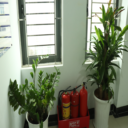

In [33]:
image_query = X_test[check_index].view(1,-1)
label_query = Y_test[check_index].view(1)
X_total= torch.cat([X_train, image_query], dim=0)
Y_total= torch.cat([Y_train, label_query], dim=0)

test_img = Function.to_pil_image(test_image[check_index])
print('Test image : {}'.format(test_label[check_index].item()))
display(test_img)

In [34]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_total.cpu().detach().numpy())

pairwise_dist_t = _pairwise_distance(X_total)
pairwise_dist_n = pairwise_dist_t.cpu().detach().numpy()

pairwise_dist_sort = np.sort(pairwise_dist_n[-1][:-1])

Query image : 4



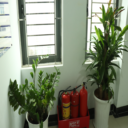



1 second similar 259 second image : 


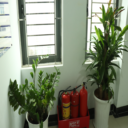



2 second similar 335 second image : 


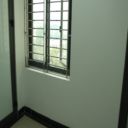



3 second similar 208 second image : 


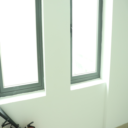



4 second similar 301 second image : 


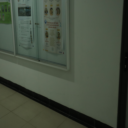



5 second similar 212 second image : 


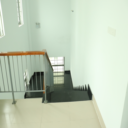

In [35]:
test_img = Function.to_pil_image(test_image[check_index])
print('Query image : {}\n'.format(test_label[check_index].item()))
display(test_img)
print("\n")

for ii in range(5):
  idx = np.where( pairwise_dist_n[-1] == pairwise_dist_sort[ii])
  print('{} second similar {} second image : '.format(ii+1,idx[0][0]))
  img = Function.to_pil_image(bef_train_image[idx[0][0]])
  #     img.save('test{}_{}.png'.format(Y_total[ii],ii))
  display(img)
  print("\n")

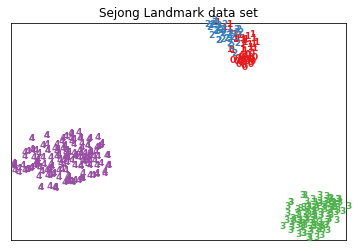

In [36]:
plot_embedding(X_tsne, Y_total,"Sejong Landmark data set")
plt.show()

In [30]:
X_tsne.shape

(347, 2)